# Retrain Flood Risk Model — step-by-step
**Purpose:** preprocess historic weather data, create realistic flood labels, train & calibrate a RandomForest, evaluate, log to MLflow, and save model + feature list for FastAPI.



In [31]:
# Run this cell only if you need to install missing packages (uncomment to run).
# !pip install -r requirements.txt
# or individual installs:
# !pip install pandas numpy scikit-learn joblib mlflow matplotlib seaborn


In [2]:
import os
import json
import joblib
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, brier_score_loss
)

import mlflow
import mlflow.sklearn

# Configuration - adjust paths if needed
RAW_CSV = "../data/Weather Dataset.csv"   # path to your raw CSV
PROCESSED_DIR = "../data/processed"
MODELS_DIR = "../models"
MLFLOW_URI = "http://127.0.0.1:5000"      # change if your mlflow server is elsewhere

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)


c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service
c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [3]:
# load a small sample to inspect columns and types
df_sample = pd.read_csv(RAW_CSV, nrows=10)
display(df_sample)
print("\nColumns:", list(df_sample.columns))


,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,01-01-2012 00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,01-01-2012 01:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,01-01-2012 02:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,01-01-2012 03:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,01-01-2012 04:00,-1.5,-3.3,88,7,4.8,101.23,Fog
5,01-01-2012 05:00,-1.4,-3.3,87,9,6.4,101.27,Fog
6,01-01-2012 06:00,-1.5,-3.1,89,7,6.4,101.29,Fog
7,01-01-2012 07:00,-1.4,-3.6,85,7,8.0,101.26,Fog
8,01-01-2012 08:00,-1.4,-3.6,85,9,8.0,101.23,Fog
9,01-01-2012 09:00,-1.3,-3.1,88,15,4.0,101.20,Fog



Columns: ['Date/Time', 'Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa', 'Weather']


In [5]:
def preprocess_raw(df):
    # Try to rename common columns
    rename_map = {}
    if 'Date/Time' in df.columns: rename_map['Date/Time'] = 'timestamp'
    if 'Temp_C' in df.columns: rename_map['Temp_C'] = 'temp'
    if 'Rel Hum_%' in df.columns: rename_map['Rel Hum_%'] = 'humidity'
    if 'Wind Speed_km/h' in df.columns: rename_map['Wind Speed_km/h'] = 'wind_speed'
    if 'Press_kPa' in df.columns: rename_map['Press_kPa'] = 'pressure'
    if 'Weather' in df.columns: rename_map['Weather'] = 'Weather'
    df = df.rename(columns=rename_map)

    # Ensure timestamp column exists and parse
    if 'timestamp' not in df.columns:
        candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
        if len(candidates) == 0:
            raise ValueError("No timestamp column found. Rename your timestamp to 'Date/Time' or 'timestamp'.")
        df = df.rename(columns={candidates[0]: 'timestamp'})

    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp']).reset_index(drop=True)

    # Convert numeric columns safely
    for col in ['temp','humidity','pressure','wind_speed']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Time features
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    # Deltas
    if 'temp' in df.columns:
        df['temp_delta'] = df['temp'].diff().fillna(0)
    else:
        df['temp_delta'] = 0.0
    if 'humidity' in df.columns:
        df['humidity_delta'] = df['humidity'].diff().fillna(0)
    else:
        df['humidity_delta'] = 0.0

    # Rain indicator: derive from Weather text if exists else fallback to 0
    if 'Weather' in df.columns:
        def rain_flag(x):
            s = str(x).lower()
            return 1 if any(k in s for k in ['rain','drizzle','shower','thunder','squall','snow']) else 0
        df['rain_1h'] = df['Weather'].apply(rain_flag)
    else:
        df['rain_1h'] = df.get('precipitation', 0).fillna(0)

    # Rolling sums for rain
    df['rain_3h'] = df['rain_1h'].rolling(3, min_periods=1).sum().fillna(0)
    df['rain_6h'] = df['rain_1h'].rolling(6, min_periods=1).sum().fillna(0)
    df['rain_24h'] = df['rain_1h'].rolling(24, min_periods=1).sum().fillna(0)
    df['rain_intensity'] = df['rain_1h']  # simple proxy

    # Ensure feature set exists
    feature_columns = [
        "temp", "humidity", "pressure", "wind_speed",
        "rain_1h", "rain_3h", "rain_6h", "rain_24h", "rain_intensity",
        "temp_delta", "humidity_delta",
        "hour", "minute", "second", "day", "month", "year"
    ]
    for c in feature_columns:
        if c not in df.columns:
            df[c] = 0.0

    return df, feature_columns


In [6]:
df_raw = pd.read_csv(RAW_CSV)
df, feature_cols = preprocess_raw(df_raw)
print("Processed shape:", df.shape)
print("Example rows:")
display(df.head())
# Save processed subset for debugging
processed_path = os.path.join(PROCESSED_DIR, "weather_processed.csv")
df.to_csv(processed_path, index=False)
print("Saved processed to:", processed_path)


Processed shape: (3456, 21)
Example rows:


,timestamp,temp,Dew Point Temp_C,humidity,wind_speed,Visibility_km,pressure,Weather,hour,minute,...,day,month,year,temp_delta,humidity_delta,rain_1h,rain_3h,rain_6h,rain_24h,rain_intensity
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog,0,0,...,1,1,2012,0.0,0.0,0,0.0,0.0,0.0,0
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog,1,0,...,1,1,2012,0.0,1.0,0,0.0,0.0,0.0,0
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog",2,0,...,1,1,2012,0.0,2.0,1,1.0,1.0,1.0,1
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog",3,0,...,1,1,2012,0.3,-1.0,1,2.0,2.0,2.0,1
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog,4,0,...,1,1,2012,0.0,0.0,0,2.0,2.0,2.0,0


Saved processed to: ../data/processed\weather_processed.csv


In [8]:
def make_label(df):
    # Shift rainfall backward to simulate "past" effect
    df['rain_24h_prev'] = df['rain_24h'].shift(1)
    df['rain_6h_prev'] = df['rain_6h'].shift(1)
    df['humidity_prev'] = df['humidity'].shift(1)
    df['pressure_prev'] = df['pressure'].shift(1)

    rain_thresh = 3.0     # e.g. 8 mm in last 24h
    humid_thresh = 75.0
    pressure_thresh = 1012.0

    label = (
        (df['rain_24h_prev'] >= rain_thresh) &
        (df['humidity_prev'] >= humid_thresh) &
        (df['pressure_prev'] <= pressure_thresh)
    ).astype(int)

    # If too few positives, relax the condition
    if label.sum() < len(df) * 0.03:
        label = (
            (df['rain_24h_prev'] >= rain_thresh * 0.6) &
            (df['humidity_prev'] >= humid_thresh - 5)
        ).astype(int)

    df.drop(columns=['rain_24h_prev', 'rain_6h_prev', 'humidity_prev', 'pressure_prev'], inplace=True)
    return label
df['flood_risk'] = make_label(df)
print("Class distribution:\n", df['flood_risk'].value_counts())


Class distribution:
 flood_risk
0    2594
1     862
Name: count, dtype: int64


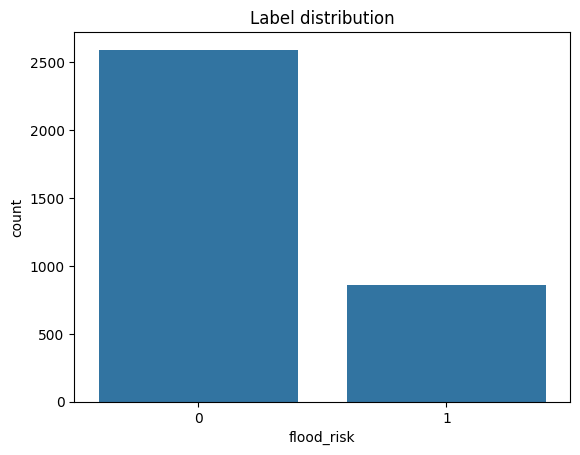

flood_risk        1.000000
rain_24h          0.646604
rain_6h           0.604862
humidity          0.584376
rain_3h           0.522817
rain_1h           0.397168
rain_intensity    0.397168
month             0.080589
wind_speed        0.034172
temp_delta        0.011241
Name: flood_risk, dtype: float64

In [9]:
# Quick EDA
sns.countplot(x=df['flood_risk'])
plt.title("Label distribution")
plt.show()

# show correlations with label
corr = df[feature_cols + ['flood_risk']].corr()['flood_risk'].sort_values(ascending=False)
display(corr.head(10))


In [10]:
# ✅ Step 1: Time-based split (avoid shuffling leakage)
df_sorted = df.sort_values('timestamp')
split_idx = int(len(df_sorted) * 0.8)

# ✅ Step 2: Use only safe features (no direct rainfall columns)
safe_features = [
    "temp", "humidity", "pressure", "wind_speed",
    "rain_1h", "rain_3h", "rain_6h", "rain_24h", "rain_intensity",
    "temp_delta", "humidity_delta",
    "hour", "day", "month", "year"
]


X_train = df_sorted.iloc[:split_idx][safe_features]
y_train = df_sorted.iloc[:split_idx]['flood_risk']
X_test = df_sorted.iloc[split_idx:][safe_features]
y_test = df_sorted.iloc[split_idx:]['flood_risk']

print("Using safe features only:", safe_features)
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train label distribution:\n", y_train.value_counts())


Using safe features only: ['temp', 'humidity', 'pressure', 'wind_speed', 'rain_1h', 'rain_3h', 'rain_6h', 'rain_24h', 'rain_intensity', 'temp_delta', 'humidity_delta', 'hour', 'day', 'month', 'year']
Train size: (2764, 15) Test size: (692, 15)
Train label distribution:
 flood_risk
0    2151
1     613
Name: count, dtype: int64


In [11]:
from sklearn.utils import resample

def oversample(X, y, strategy="equal"):
    """
    Oversample the minority class to balance the dataset.

    strategy:
        "equal" -> make both classes equal in count (default)
        "moderate" -> oversample minority to 70% of majority (less risk of overfitting)
    """
    df_train = pd.concat([X, y.rename('flood_risk')], axis=1)
    majority = df_train[df_train['flood_risk'] == 0]
    minority = df_train[df_train['flood_risk'] == 1]

    # Skip if already balanced enough
    ratio = len(minority) / len(majority)
    if ratio > 0.8:
        print("⚖️ Dataset already balanced, skipping oversampling.")
        return X, y

    if strategy == "equal":
        target_samples = len(majority)
    elif strategy == "moderate":
        target_samples = int(len(majority) * 0.7)
    else:
        raise ValueError("strategy must be 'equal' or 'moderate'")

    # Oversample minority class
    minority_up = resample(
        minority,
        replace=True,
        n_samples=target_samples,
        random_state=42
    )

    df_bal = pd.concat([majority, minority_up]).sample(frac=1, random_state=42).reset_index(drop=True)
    yb = df_bal['flood_risk']
    Xb = df_bal.drop(columns=['flood_risk'])

    print(f"✅ Oversampling done — strategy: {strategy}")
    print("Before:", y.value_counts().to_dict())
    print("After:", yb.value_counts().to_dict())

    return Xb, yb


# Example usage
X_train_bal, y_train_bal = oversample(X_train, y_train, strategy="equal")
print("Balanced train size:", X_train_bal.shape)


✅ Oversampling done — strategy: equal
Before: {0: 2151, 1: 613}
After: {0: 2151, 1: 2151}
Balanced train size: (4302, 15)


In [12]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train_bal, y_train_bal)
print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [13]:
calibrator = CalibratedClassifierCV(best_rf, cv=3, method='isotonic')
calibrator.fit(X_train_bal, y_train_bal)


,estimator,RandomForestC...ndom_state=42)
,method,'isotonic'
,cv,3
,n_jobs,None
,ensemble,'auto'
,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0


Accuracy: 0.9797687861271677
F1: 0.9714285714285714
Precision: 0.9875518672199171
Recall: 0.9558232931726908
Brier loss: 0.01955225912002994

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       443
           1       0.99      0.96      0.97       249

    accuracy                           0.98       692
   macro avg       0.98      0.97      0.98       692
weighted avg       0.98      0.98      0.98       692



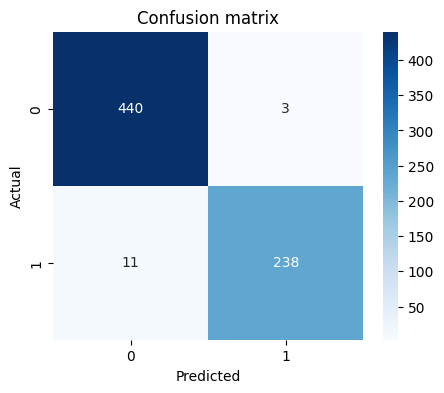

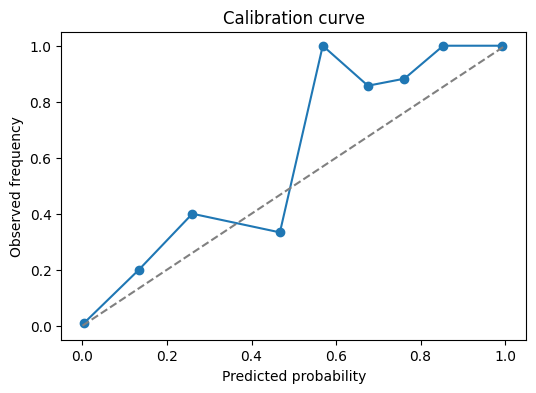

In [14]:
y_pred = calibrator.predict(X_test)
y_proba = calibrator.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_proba)

print("Accuracy:", acc)
print("F1:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("Brier loss:", brier)
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curve")
plt.show()


In [95]:
# configure mlflow
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment("Flood_Risk_Retrain")

with mlflow.start_run(run_name=f"retrain_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"):
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1", float(f1))
    mlflow.log_metric("precision", float(prec))
    mlflow.log_metric("recall", float(rec))
    mlflow.log_metric("brier_loss", float(brier))
    # save visual artifacts
    cm_path = os.path.join(PROCESSED_DIR, "cm.png")
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title("Confusion matrix")
    plt.savefig(cm_path); plt.close()
    mlflow.log_artifact(cm_path)
    # log model
    mlflow.sklearn.log_model(calibrator, "calibrated_rf_model")
    print("Logged run to MLflow")


c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\_distutils_hack\__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Logged run to MLflow


In [118]:
import os, json, joblib
from datetime import datetime

# Define model paths
out_model = os.path.join(MODELS_DIR, "optimized_rf_v2.pkl")
joblib.dump(calibrator, out_model)
print("✅ Saved new model to:", out_model)

# Save feature list used by API
feature_cols_path = os.path.join(MODELS_DIR, "feature_columns.json")
with open(feature_cols_path, "w") as f:
    json.dump(feature_cols, f)
print("✅ Saved feature_columns.json to:", feature_cols_path)

# Backup old production model if exists
prod_model = os.path.join(MODELS_DIR, "models/optimized_rf_v2_.pkl")
if os.path.exists(prod_model):
    backup_name = os.path.join(
        MODELS_DIR, 
        f"optimized_rf_model_backup_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.pkl"
    )
    os.replace(prod_model, backup_name)
    print("🗄️ Backed up existing production model to:", backup_name)

# (Optional) promote new model to production after testing
# os.replace(out_model, prod_model)


✅ Saved new model to: ../models\optimized_rf_v2.pkl
✅ Saved feature_columns.json to: ../models\feature_columns.json


In [15]:
# Example of how to call FastAPI locally after you deploy model file to models/
# This cell will not work unless your FastAPI is running and reading new model from MODELS_DIR.
import requests, json
sample = X_test.iloc[0].to_dict()
# Ensure types are JSON-serializable
payload = {k: (float(v) if np.isscalar(v) else v) for k,v in sample.items()}
API_URL = "http://127.0.0.1:8000/predict_flood"
try:
    r = requests.post(API_URL, json=payload, timeout=5)
    print("Status:", r.status_code, r.text)
except Exception as e:
    print("API call failed:", e)


API call failed: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /predict_flood (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001CBF1A52D50>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))


In [108]:
print(list(X_train.columns))


['temp', 'humidity', 'pressure', 'wind_speed', 'rain_1h', 'rain_3h', 'rain_6h', 'rain_24h', 'rain_intensity', 'temp_delta', 'humidity_delta', 'hour', 'day', 'month', 'year']


In [120]:
import json

new_features = [
    "temp", "humidity", "pressure", "wind_speed",
    "rain_1h", "rain_3h", "rain_6h", "rain_24h", "rain_intensity",
    "temp_delta", "humidity_delta",
    "hour", "day", "month", "year"
]

with open("../models/feature_columns.json", "w") as f:
    json.dump(new_features, f)


print("✅ feature_columns.json updated successfully!")


✅ feature_columns.json updated successfully!


In [117]:
import requests

API_URL = "http://127.0.0.1:8000/predict_flood"
sample = {
    "temp": 25.0,
    "humidity": 80,
    "pressure": 101.3,
    "wind_speed": 5,
    "temp_delta": 0.5,
    "humidity_delta": 1,
    "rain_24h":0.48,
    "hour": 14,
    "day": 20,
    "month": 10,
    "year": 2025
}

r = requests.post(API_URL, json=sample)
print(r.status_code, r.json())


200 {'flood_risk': 0, 'flood_probability': 0.0}


In [81]:
print(y_test.value_counts())


flood_risk
0    443
1    249
Name: count, dtype: int64


In [82]:
sample_df = X_test.copy()
sample_df["actual"] = y_test.values
sample_df["predicted"] = y_pred
print(sample_df.sample(10))


      temp  humidity  pressure  wind_speed  rain_1h  rain_3h  rain_6h  \
3113   3.5        43    102.47           7        0      0.0      0.0   
3316  -2.7        80    101.38          11        0      0.0      0.0   
3341   2.7        77    101.07           9        0      0.0      1.0   
3197  -2.7        84    101.75          11        0      1.0      1.0   
3292  -3.9        68    102.33          11        0      0.0      0.0   
3028  -4.0        85    102.02          11        0      0.0      0.0   
2864   4.8        68    101.57          17        0      0.0      0.0   
3153   4.2        84    101.83           7        0      0.0      0.0   
2779   9.7        57    102.03          15        0      0.0      0.0   
3317  -2.2        78    101.30          11        0      0.0      0.0   

      rain_24h  rain_intensity  temp_delta  humidity_delta  hour  day  month  \
3113       0.0               0        -0.1             1.0    17   10     11   
3316       0.0               0      

### Rollout checklist (do these before replacing prod model)
- [ ] Inspect MLflow run (metrics and artifacts).
- [ ] Test model on time-split holdout and real API payloads — compare old vs new predictions for same inputs.
- [ ] Run the FastAPI locally with new model (copy file into `models/` and restart FastAPI) and hit `/predict_flood`.
- [ ] Verify calibration and false positive rate are acceptable.
- [ ] Create a staged rollout: keep old model and route small % traffic to new model if possible or test in staging.
- [ ] Backup old model (you already do this step in the script).
- [ ] Monitor dashboard & logs after rollout for unexpected spikes.
